<a href="https://colab.research.google.com/github/DanieleAngioni97/Introductory-Seminar-PyTorch/blob/main/notebooks/05_autoencoders_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading the MNIST dataset and preparing the noisy data**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(x_test.shape)
print(type(x_train))

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
<class 'numpy.ndarray'>


In [ ]:
noise_factor = 0.3
#loc and scale being mean and std
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0,
                                                        scale=1.0,
                                                        size=x_test.shape)

#clip pixel under 0 and above 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

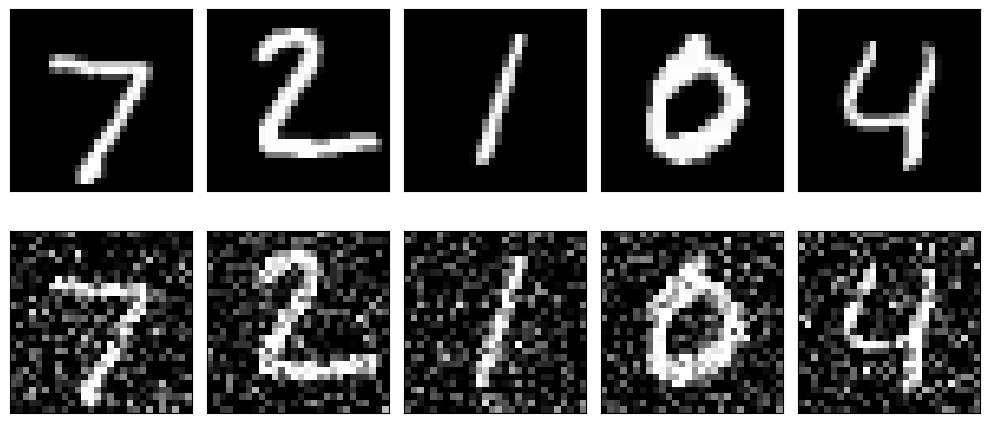

In [ ]:
n_images = 5       #images to be visualized
bias = 0    #starting index from the test set for the visualization
fig, axs = plt.subplots(nrows=2, ncols=n_images, figsize=(10, 5))
for i in range(n_images):
    axs[0, i].imshow(x_test[bias + i], cmap='gray')
    axs[0, i].get_xaxis().set_visible(False)
    axs[0, i].get_yaxis().set_visible(False)

    axs[1, i].imshow(x_test_noisy[bias + i], cmap='gray')
    axs[1, i].get_xaxis().set_visible(False)
    axs[1, i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.show()

# **Architecture of the network**

1/1 [==============================] - 0s 340ms/step
(1, 28, 28, 1)


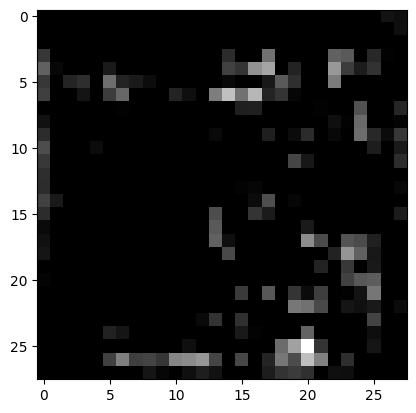

In [ ]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
def create_autoencoder():
    encoder = tf.keras.models.Sequential([
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        AveragePooling2D((2, 2), padding='same'), #14x14
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        AveragePooling2D((2, 2), padding='same'),   #7x7
        Conv2D(128, (3, 3), activation='relu', padding='same')
    ])
    # latent representation has shape (7, 7, 128)
    decoder = tf.keras.models.Sequential([
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)), #14x14
        Conv2D(64, (5, 5), activation='relu', padding='same'),
        Conv2D(64, (5, 5), activation='relu', padding='same'),
        UpSampling2D((2, 2)), #28x28
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(1, (3, 3), activation='relu', padding='same')
    ])
    autoencoder = tf.keras.models.Sequential([encoder, decoder])
    return autoencoder

autoencoder = create_autoencoder()
out = autoencoder.predict(x_test[:1])
print(out.shape)
plt.imshow(out[0], cmap='gray')

# **Training the autoencoder**

In [ ]:
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError

epochs = 10
autoencoder = create_autoencoder()  #create the architecture
optim = SGD(learning_rate=0.001, momentum=0.9)
loss = MeanSquaredError()
autoencoder.compile(optimizer=optim, loss=loss)

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                verbose=2,
                validation_data=(x_test_noisy, x_test))
autoencoder.save_weights("autoencoder.h5")

Epoch 1/10
469/469 - 13s - loss: 0.0745 - val_loss: 0.0575 - 13s/epoch - 28ms/step
Epoch 2/10
469/469 - 11s - loss: 0.0484 - val_loss: 0.0403 - 11s/epoch - 24ms/step
Epoch 3/10
469/469 - 11s - loss: 0.0362 - val_loss: 0.0320 - 11s/epoch - 24ms/step
Epoch 4/10
469/469 - 11s - loss: 0.0294 - val_loss: 0.0266 - 11s/epoch - 24ms/step
Epoch 5/10
469/469 - 11s - loss: 0.0253 - val_loss: 0.0234 - 11s/epoch - 25ms/step
Epoch 6/10
469/469 - 12s - loss: 0.0226 - val_loss: 0.0212 - 12s/epoch - 25ms/step
Epoch 7/10
469/469 - 11s - loss: 0.0208 - val_loss: 0.0196 - 11s/epoch - 24ms/step
Epoch 8/10
469/469 - 11s - loss: 0.0194 - val_loss: 0.0185 - 11s/epoch - 24ms/step
Epoch 9/10
469/469 - 12s - loss: 0.0184 - val_loss: 0.0176 - 12s/epoch - 25ms/step
Epoch 10/10
469/469 - 12s - loss: 0.0175 - val_loss: 0.0168 - 12s/epoch - 25ms/step


# **Evaluate the model**

1/1 [==============================] - 0s 56ms/step


<Figure size 4000x2000 with 0 Axes>

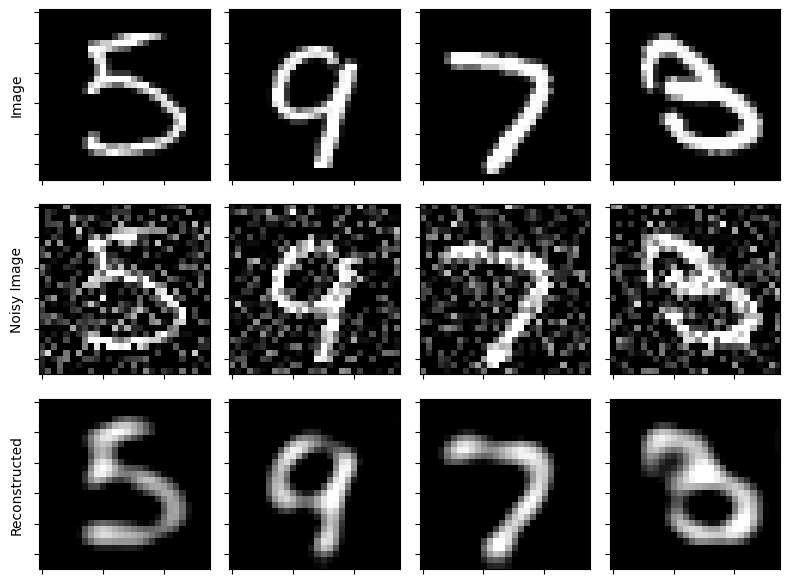

In [ ]:
autoencoder = create_autoencoder()  # instantiate the autoencoder model
out = autoencoder.predict(x_test[:1])   # build the graph
autoencoder.load_weights("autoencoder.h5")  # load the pretrained weights

n_images = 4 #images to be visualized
bias = 15 #starting index from the test set for the visualization
plt.figure(figsize=(40, 20))

input_images = x_test_noisy[bias : bias + n_images]
target_images = x_test[bias : bias + n_images]
output_imgs = autoencoder.predict(x_test_noisy[bias : bias + n_images])
output_imgs = np.clip(output_imgs, 0., 1.)

nrows = 3
figdim = 2
fig, axs = plt.subplots(nrows=nrows, ncols=n_images, figsize=(figdim*n_images, figdim*nrows))

for i in range(n_images):
    axs[0, i].imshow(target_images[i], cmap='gray')
    axs[0, i].set_yticklabels([])
    axs[0, i].set_xticklabels([])

    axs[1, i].imshow(input_images[i], cmap='gray')
    axs[1, i].set_yticklabels([])
    axs[1, i].set_xticklabels([])

    axs[2, i].imshow(output_imgs[i], cmap='gray')
    axs[2, i].set_yticklabels([])
    axs[2, i].set_xticklabels([])

axs[0, 0].set_ylabel('Image')
axs[1, 0].set_ylabel('Noisy Image')
axs[2, 0].set_ylabel('Reconstructed')

fig.tight_layout()
fig.show()

# Image Morphing

In [ ]:
x1 = x_test[:1]
x2 = x_test[1:2]
encoder = autoencoder.layers[0]
latent1 = encoder.predict(x1)
latent2 = encoder.predict(x2)
print(latent1.shape)
print(latent2.shape)

1/1 [==============================] - 0s 16ms/step
(1, 7, 7, 128)
(1, 7, 7, 128)


In [ ]:
latent_sweep = []
for alpha in np.linspace(0, 1, 5):
    intermediate_latent = alpha * latent1 + (1 - alpha) * latent2
    latent_sweep.append(intermediate_latent)

In [ ]:
decoder = autoencoder.layers[1]
output_list = []
for latent in latent_sweep:
    output = decoder.predict(latent)
    output_list.append(output)

1/1 [==============================] - 0s 32ms/step


In [ ]:
len(output_list)

5

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


IndexError: index 4 is out of bounds for axis 0 with size 4

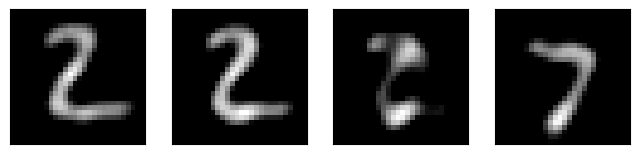

In [ ]:
nrows = 1
ncols = len(output_list)
figdim = 2
fig, axs = plt.subplots(nrows=nrows, ncols=n_images, figsize=(figdim*n_images, figdim*nrows))

for i in range(len(output_list)):
    output = output_list[i][0]
    print(output.shape)
    axs[i].imshow(output, cmap='gray')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
fig.tight_layout()
fig.show()